In [17]:
import tensorflow as tf
from tensorflow import keras 
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

In [20]:
Train_referencePath = r'D:\Project_code\fingerPrint\dataset\Genuine\(2)Reference'
Train_alignedPath = r'D:\Project_code\fingerPrint\dataset\Genuine\(2)Aligned'

In [23]:
referenceTrain = []
alignedTrain = []
Train_sourceImageList = os.listdir(Train_referencePath)
Train_sourceImageList.sort(key=lambda x:int(x[:-4]))
Train_alignedImageList = os.listdir(Train_alignedPath)
Train_alignedImageList.sort(key=lambda x:int(x[:-4]))
for i in Train_sourceImageList:
    imagePath = os.path.join(Train_referencePath,i)   #读取reference图像路径
    referenceImage = image.load_img(imagePath)   #加载图像成jpg格式
    img_array = image.img_to_array(referenceImage)   #转换成array格式
    referenceTrain.append(img_array)   #保存至列表
for i in Train_alignedImageList:
    imagePath = os.path.join(Train_alignedPath,i)
    alignedImage = image.load_img(imagePath)
    img_array = image.img_to_array(alignedImage)
    alignedTrain.append(img_array)

In [24]:
print("Original type:%s"%type(referenceTrain))
referenceTrain = np.array(referenceTrain)   #转换图像类型
alignedTrain = np.array(alignedTrain)
print("Converted type:%s"%type(referenceTrain))	

Original type:<class 'list'>
Converted type:<class 'numpy.ndarray'>


In [9]:
referenceTrain = referenceTrain.astype('float32')/255   #图像归一化
alignedTrain = alignedTrain.astype('float32')/255

In [10]:
print(alignedTrain[-1].shape)   #查看图像尺寸

(356, 328, 3)


In [11]:
labels = [1]*139 + [0]*139   #制作图像标签
labels = np.array(labels).astype('float32')   #标签类型转换
print(type(labels))

<class 'numpy.ndarray'>


In [12]:
def euclidean_distance(vects):   #向量欧式距离计算
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))  

def eucl_dist_output_shape(shapes):   #结果输出维度
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):   #对抗损失函数
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):   #模型训练评判指标
    return K.mean(K.equal(y_true, K.cast(y_pred <0.5, y_true.dtype)))

In [28]:
def MDCNN_network(input_shape):   #模型搭建
    input = keras.layers.Input(shape = input_shape)
    x = keras.layers.Conv2D(filters=2,kernel_size=3,input_shape=(356,328,3))(input)
    x = keras.activations.selu(x)
    x1 = keras.layers.Conv2D(filters=4,kernel_size=3,strides=1,padding='same')(x)
    x1 = keras.activations.selu(x1)
    x2 = keras.layers.Conv2D(filters=4,kernel_size=3,strides=1,dilation_rate=(2,2),padding='same')(x)
    x2 = keras.activations.selu(x2)
    x3 = keras.layers.Conv2D(filters=4,kernel_size=3,strides=1,dilation_rate=(3,3),padding='same')(x)
    x3 = keras.activations.selu(x3)
    x = keras.layers.Add()([x1,x2,x3])
    x = keras.layers.Conv2D(filters=8,kernel_size=3)(x)
    x = keras.activations.selu(x)
    x1 = keras.layers.Conv2D(filters=16,kernel_size=3,strides=2)(x)
    x1 = keras.activations.selu(x1)
    x2 = keras.layers.Conv2D(filters=16,kernel_size=3,strides=2)(x)
    x2 = keras.activations.selu(x2)
    x3 = keras.layers.Conv2D(filters=16,kernel_size=3,strides=2)(x)
    x3 = keras.activations.selu(x3)
    x = keras.layers.Add()([x1,x2,x3])
    x = keras.layers.Conv2D(filters=32,kernel_size=3)(x)
    x = keras.activations.selu(x)
    x = keras.layers.Conv2D(filters=64,kernel_size=3,strides=2)(x)
    x = keras.activations.selu(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(10)(x)
    return keras.models.Model(input, x)

In [29]:
base_network = MDCNN_network(sourceTrain[0].shape)
input_a = keras.Input(shape=sourceTrain[0].shape)
input_b = keras.Input(shape=alignedTrain[0].shape)
processed_a = base_network(input_a)   #模型一路输入
processed_b = base_network(input_b)   #模型另一路输入
distance = keras.layers.Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = keras.models.Model([input_a, input_b], distance)   #模型拼接

In [31]:
model.compile(loss=contrastive_loss,optimizer='adam',metrics=[accuracy])

In [32]:
history=model.fit([sourceTrain, alignedTrain],labels,batch_size=1,epochs=10,verbose=1)

Epoch 1/10
278/278 [==============================] - 110s 386ms/step - loss: 26163.9050 - accuracy: 0.4969
Epoch 2/10
278/278 [==============================] - 104s 374ms/step - loss: 268.0472 - accuracy: 0.5372
Epoch 3/10
278/278 [==============================] - 106s 382ms/step - loss: 14.5058 - accuracy: 0.5803
Epoch 4/10
278/278 [==============================] - 96s 345ms/step - loss: 6.9271 - accuracy: 0.5130
Epoch 5/10
278/278 [==============================] - 95s 341ms/step - loss: 2.9994 - accuracy: 0.5511
Epoch 6/10
278/278 [==============================] - 96s 344ms/step - loss: 2.9702 - accuracy: 0.5324
Epoch 7/10
278/278 [==============================] - 96s 346ms/step - loss: 1.6523 - accuracy: 0.5396
Epoch 8/10
278/278 [==============================] - 97s 348ms/step - loss: 0.9073 - accuracy: 0.5372
Epoch 9/10
278/278 [==============================] - 96s 346ms/step - loss: 0.9658 - accuracy: 0.4978
Epoch 10/10
278/278 [==============================] - 97s 348m

In [33]:
def testImage_preprocessing(image_path):   #测试图像预处理函数
    testImage = image.load_img(image_path)   #图像加载
    plt.imshow(testImage)
    plt.show()
    testImage = image.img_to_array(testImage).astype('float32')/255
    testImage = np.expand_dims(testImage,axis=0)   #图像维度增添以满足模型输入要求
    return testImage

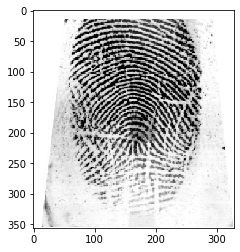

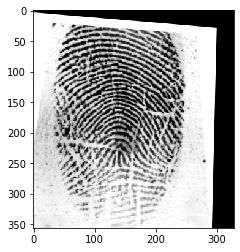

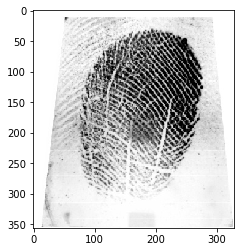

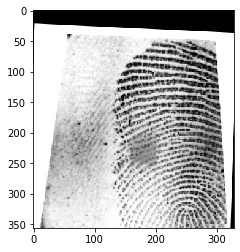

The score of same fingerprint:4.648660
The score of different fingerprint:1.270272


In [36]:
same_path_1 = r'1.png' 
same_path_2 = r'2.png'
different_path_1 = '3.png'
different_path_2 = '4.png'
same_testImage_1 = testImage_preprocessing(same_path_1)
same_testImage_2 = testImage_preprocessing(same_path_2)
different_testImage_1 = testImage_preprocessing(different_path_1)
different_testImage_2 = testImage_preprocessing(different_path_2)
sameScore = model.predict([same_testImage_1,same_testImage_2])   #相同指纹距离预测
differentScore = model.predict([different_testImage_1,different_testImage_2])   #不同指纹距离预测
print("The score of same fingerprint:%f"%sameScore[0][0])
print("The score of different fingerprint:%f"%differentScore[0][0])	